
Датасет - https://keras.io/api/datasets/mnist

Сеть - https://keras.io/api/applications/xception

In [ ]:
#import necessary libraries

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(train_image, train_label), (test_image, test_label) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Данные содержат 60000 тренировочных изображений 28х28 и 10000 тестовых

In [ ]:
print(train_image.shape)
print(len(train_label))
print(test_image.shape)
print(len(test_label))

(60000, 28, 28)
60000
(10000, 28, 28)
10000


In [ ]:
# Нормализация значений, чтобы они были от 0 до 1
train_image = train_image / 255.0
test_image = test_image / 255.0

Выведем первые 10 элементов

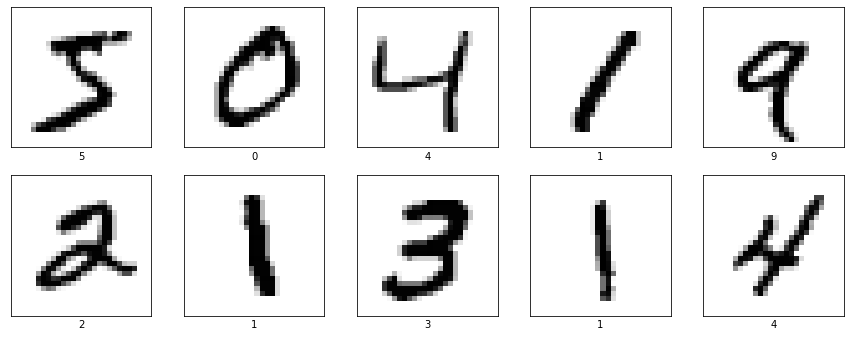

In [ ]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_image[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel(train_label[i])
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical 
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

In [ ]:
train_image = train_image.reshape(-1, 28, 28, 1)
test_image = test_image.reshape(-1, 28, 28, 1)

In [ ]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    
    return x

In [ ]:
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x


In [ ]:
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x


In [ ]:
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor


In [ ]:
# exit flow

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = 10, activation = 'softmax')(x)
    
    return x


In [ ]:
# model

input = Input(shape = (28,28,1))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)


In [ ]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.fit(train_image, train_label,  epochs=5, batch_size=128, validation_split=0.2, verbose=1, shuffle = True)

Epoch 1/5
375/375 [==============================] - 93s 150ms/step - loss: 0.1701 - accuracy: 0.9473 - val_loss: 2.3454 - val_accuracy: 0.1060
Epoch 2/5
375/375 [==============================] - 54s 145ms/step - loss: 0.0606 - accuracy: 0.9823 - val_loss: 0.2061 - val_accuracy: 0.9328
Epoch 3/5
375/375 [==============================] - 54s 145ms/step - loss: 0.0500 - accuracy: 0.9852 - val_loss: 0.3542 - val_accuracy: 0.9143
Epoch 4/5
375/375 [==============================] - 54s 145ms/step - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.0939 - val_accuracy: 0.9768
Epoch 5/5
375/375 [==============================] - 55s 145ms/step - loss: 0.0286 - accuracy: 0.9913 - val_loss: 0.1887 - val_accuracy: 0.9526


In [ ]:
preds = model.evaluate(test_image, test_label)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 7s 21ms/step - loss: 0.1720 - accuracy: 0.9550
Loss = 0.17195983231067657
Test Accuracy = 0.9549999833106995


In [ ]:
predicted_label = model.predict(test_image)

In [ ]:
test_image = test_image.reshape(-1, 28, 28)

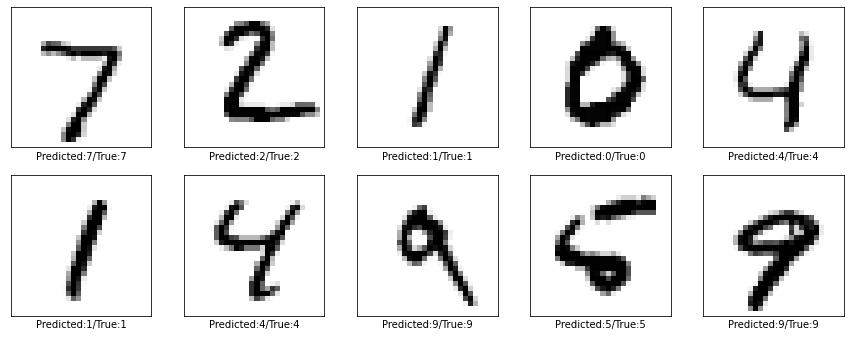

In [ ]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_image[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + str(np.argmax(predicted_label[i])) + '/True:' + str(np.argmax(test_label[i])))
plt.show()

Добавление шума

In [ ]:
# Добавление равномерного шума
def add_uniform_noise(signal, snr):
    ''' 
    signal: np.ndarray
    snr: float

    returns -> np.ndarray
    '''

    mu, sigma = 3, 0.1
    noise = np.random.uniform(mu, sigma, signal.shape)

    # Generate the noise as you did
    #noise = acoustics.generator.white(signal.size).reshape(*signal.shape)
    # For the record I think np.random.random does exactly the same thing

    # work out the current SNR
    current_snr = np.mean(signal) / np.std(noise)

    # scale the noise by the snr ratios (smaller noise <=> larger snr)
    noise *= (current_snr / snr)

    # return the new signal with noise
    return signal + noise

In [ ]:
# Добавление нормального шума
def add_normal_noise(signal, snr):
    ''' 
    signal: np.ndarray
    snr: float

    returns -> np.ndarray
    '''

    mu, sigma = 3, 0.1
    noise = np.random.normal(mu, sigma, signal.shape)

    # Generate the noise as you did
    #noise = acoustics.generator.white(signal.size).reshape(*signal.shape)
    # For the record I think np.random.random does exactly the same thing

    # work out the current SNR
    current_snr = np.mean(signal) / np.std(noise)

    # scale the noise by the snr ratios (smaller noise <=> larger snr)
    noise *= (current_snr / snr)

    # return the new signal with noise
    return signal + noise

In [ ]:
# Количество изображений
img_noise = 10000;

Равномерный шум, ОСШ = 5

In [ ]:
img_noise_uniform_5 = np.zeros((img_noise, 28, 28))
for i in range(img_noise):
    img_noise_uniform_5[i] = add_uniform_noise(test_image[i], 5)

In [ ]:
label_predicted_noise_uniform_5 = model.predict(img_noise_uniform_5)

In [ ]:
preds = model.evaluate(img_noise_uniform_5, test_label[0:img_noise])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 7s 20ms/step - loss: 0.2443 - accuracy: 0.9429
Loss = 0.24434135854244232
Test Accuracy = 0.9429000020027161


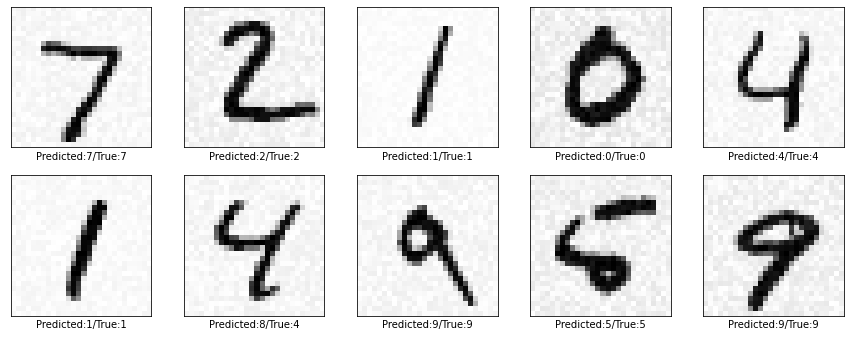

In [ ]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_noise_uniform_5[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + str(np.argmax(label_predicted_noise_uniform_5[i])) + '/True:' + str(np.argmax(test_label[i])))
plt.show()

Равномерный шум, ОСШ = 20

In [ ]:
img_noise_uniform_20 = np.zeros((img_noise, 28, 28))
for i in range(img_noise):
    img_noise_uniform_20[i] = add_uniform_noise(test_image[i], 20)

In [ ]:
label_predicted_noise_uniform_20 = model.predict(img_noise_uniform_20)

In [ ]:
preds = model.evaluate(img_noise_uniform_20, test_label[0:img_noise])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 6s 20ms/step - loss: 0.1721 - accuracy: 0.9554
Loss = 0.172132208943367
Test Accuracy = 0.9553999900817871


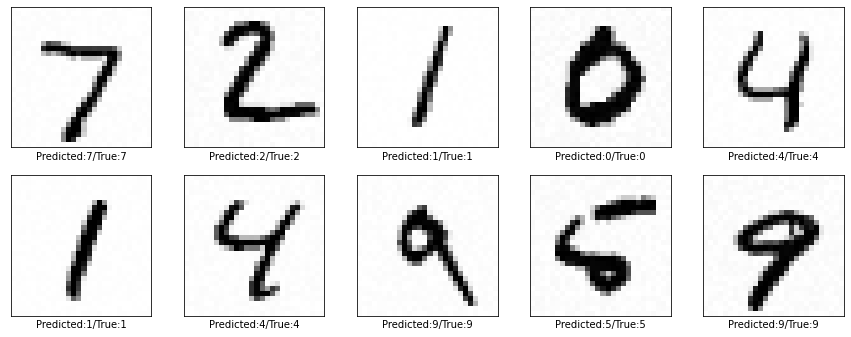

In [ ]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_noise_uniform_20[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + str(np.argmax(label_predicted_noise_uniform_20[i])) + '/True:' + str(np.argmax(test_label[i])))
plt.show()

Нормальный шум, ОСШ = 5

In [ ]:
img_noise_normal_5 = np.zeros((img_noise, 28, 28))
for i in range(img_noise):
    img_noise_normal_5[i] = add_normal_noise(test_image[i], 5)

In [ ]:
label_predicted_noise_normal_5 = model.predict(img_noise_normal_5)

In [ ]:
preds = model.evaluate(img_noise_normal_5, test_label[0:img_noise])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 7s 21ms/step - loss: 4.7833 - accuracy: 0.2687
Loss = 4.783339023590088
Test Accuracy = 0.2687000036239624


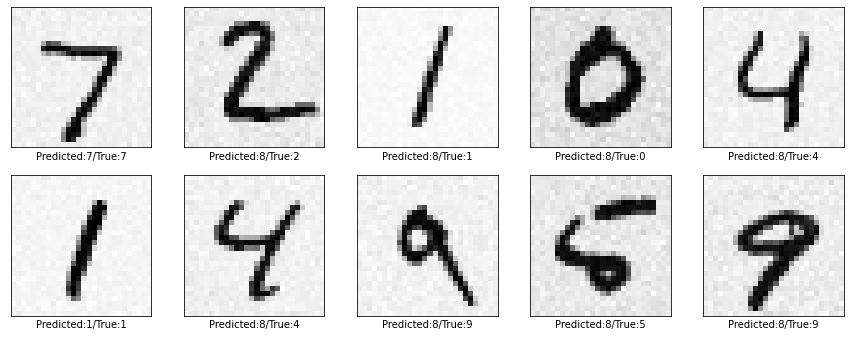

In [ ]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_noise_normal_5[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + str(np.argmax(label_predicted_noise_normal_5[i])) + '/True:' + str(np.argmax(test_label[i])))
plt.show()

Нормальный шум, ОСШ = 20

In [ ]:
img_noise_normal_20 = np.zeros((img_noise, 28, 28))
for i in range(img_noise):
    img_noise_normal_20[i] = add_normal_noise(test_image[i], 20)

In [ ]:
label_predicted_noise_normal_20 = model.predict(img_noise_normal_20)

In [ ]:
preds = model.evaluate(img_noise_normal_20, test_label[0:img_noise])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 6s 20ms/step - loss: 3.3757 - accuracy: 0.4339
Loss = 3.37565541267395
Test Accuracy = 0.43389999866485596


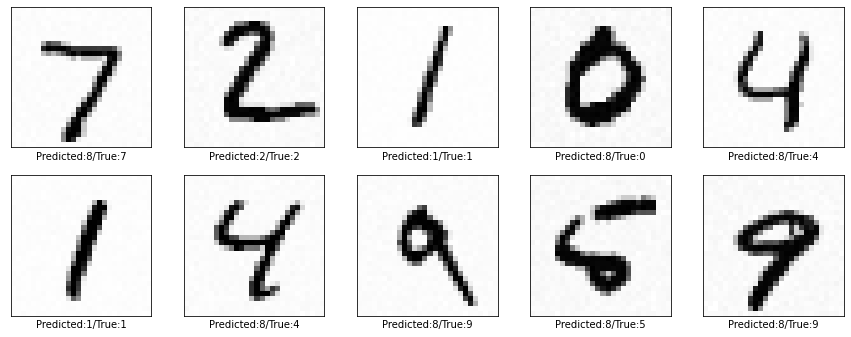

In [ ]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_noise_normal_20[i], cmap=plt.cm.binary) #, cmap=plt.cm.binary
    plt.xlabel('Predicted:' + str(np.argmax(label_predicted_noise_normal_20[i])) + '/True:' + str(np.argmax(test_label[i])))
plt.show()

Вывод слоев

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f92e73f23d0> False
<keras.layers.convolutional.Conv2D object at 0x7f92e78c8f10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f92e79a8790> False
<keras.layers.advanced_activations.ReLU object at 0x7f92e79a8f50> False
<keras.layers.convolutional.Conv2D object at 0x7f92e79a8c90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f92e743e510> False
<keras.layers.advanced_activations.ReLU object at 0x7f92e73f2910> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f92e78ed8d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f92e7ab0090> False
<keras.layers.advanced_activations.ReLU object at 0x7f92e7b4e390> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f92e7b4edd0> False
<keras.layers.convolutional.Conv2D object at 0x7f92e7b48ad0> False
<keras.layers.normalization.batch_normalization.BatchNormalizatio